<a href="https://colab.research.google.com/github/aisyahnisa160820/Early-Detection-of-Asymptomatic-COVID-19-Using-ANN/blob/main/FIX_Alhamdulillah__ANN_Forced_Cough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
 # feature extractoring and preprocessing data
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
import pathlib 
import csv

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

import tensorflow as tf

#Keras
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# from keras.utils import to_categorical
from keras.models import Sequential, Model, load_model
# from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D, UpSampling2D, Input
# from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import optimizers
from keras.regularizers import l1
from keras.utils.vis_utils import plot_model
from datetime import datetime
from sklearn import metrics
import librosa, librosa.display, os, csv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pylab
plt.switch_backend('agg')
import itertools
import scipy as sp
from scipy import signal
import xgboost as xgb
import joblib
from glob import glob
import urllib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from tensorflow.keras.utils import to_categorical 

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Basic Libraries

import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler

Connecting Kaggle to Collab to accsess dataset 

In [ ]:
!pip install -q kaggle
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aisyahnisa","key":"2f2762326b22711478e2e034022ea816"}'}

In [ ]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d 'himanshu007121/coughclassifier-trial'

 94% 89.0M/94.9M [00:00<00:00, 126MB/s] 
100% 94.9M/94.9M [00:00<00:00, 111MB/s]


In [ ]:
import zipfile,os,shutil

In [ ]:
fileZip = "coughclassifier-trial.zip"
extracZip = zipfile.ZipFile(fileZip, 'r')
extracZip.extractall("datasets")

In [ ]:
#Loading CSV file
train_csv = pd.read_csv("../content/datasets/cough_trial_extended.csv")
# dataset = "../input/coughclassifier-trial/cough_trial_extended.csv"
train_csv

,file_properties,class
0,0v8MGxNetjg_ 10.000_ 20.000.wav,not_covid
1,1j1duoxdxBg_ 70.000_ 80.000.wav,not_covid
2,1MSYO4wgiag_ 120.000_ 130.000.wav,not_covid
3,1PajbAKd8Kg_ 0.000_ 10.000.wav,not_covid
4,cov1.wav,covid
...,...,...
165,-bZrDCS8KAg_ 70.000_ 80.000.wav,not_covid
166,-ej81N6Aqo4_ 0.000_ 8.000.wav,not_covid
167,-gvLnl1smfs_ 90.000_ 100.000.wav,not_covid
168,-hu5q-Nn4BM_ 70.000_ 80.000.wav,not_covid


In [ ]:
train_csv['class'].unique()

array(['not_covid', 'covid'], dtype=object)

In [ ]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
for i in range(tot_rows):
    source = train_csv['file_properties'][i]
    filename = '../content/datasets/trial_covid/'+source
    y,sr = librosa.load(filename, mono=True, duration=10)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap=cmap, sides='default', mode='default', scale='dB');
    plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [ ]:
train_csv.shape

(170, 2)

## Extracting features from Spectrogram


We will extract

* Mel-frequency cepstral coefficients (MFCC)(20 in number)
* Spectral Centroid,
* Zero Crossing Rate
* Chroma Frequencies
* Spectral Roll-off.

In [ ]:
header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
for i in range(1, 21):
    header += f' mfcc{i}'
header += ' label'
header = header.split()

## Writing data to csv file

We write the data to a csv file

In [ ]:
file = open('data_new_extended.csv', 'w')
with file:
    writer = csv.writer(file)
    writer.writerow(header)
for i in range(tot_rows):
        source = train_csv['file_properties'][i]
        file_name = '../content/datasets/trial_covid/'+source
        y,sr = librosa.load(file_name, mono=True, duration=10)
        chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
        rmse = librosa.feature.rms(y=y)
        spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        mfcc = librosa.feature.mfcc(y=y, sr=sr)
        to_append = f'{source[:-3].replace(".", "")} {np.mean(chroma_stft)} {np.mean(rmse)} {np.mean(spec_cent)} {np.mean(spec_bw)} {np.mean(rolloff)} {np.mean(zcr)}'    
        for e in mfcc:
            to_append += f' {np.mean(e)}'
        
        file = open('data_new_extended.csv', 'a')
        with file:
            writer = csv.writer(file)
            writer.writerow(to_append.split())

# Analysing the Data in Pandas

In [ ]:
data = pd.read_csv('../content/data_new_extended.csv')
data

,filename,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0v8MGxNetjg_,10000_,20000.000000,0.514589,0.037597,1616.983935,1387.845689,2893.542905,0.111801,-383.045380,108.191742,-34.388645,1.972879,-2.841828,-4.934170,-0.039402,-7.521399,-8.890970,-0.840161,-1.556599,-7.091966,0.066338,-0.640701,-2.815719,-1.418573,-3.267711,-3.561311,-2.674301,-4.100836
1j1duoxdxBg_,70000_,80000.000000,0.473393,0.006150,2827.965336,2270.790227,4802.578771,0.171144,-458.214539,66.423210,-26.776094,47.934292,-13.144928,-7.023364,13.877339,-0.373092,5.173618,8.433851,-5.395445,-1.580244,3.587544,-1.028000,5.086622,3.650268,3.114744,-2.224480,1.842688,2.040787
1MSYO4wgiag_,120000_,130000.000000,0.554101,0.021146,3050.236109,2724.754754,6346.874150,0.198418,-341.467529,65.277298,-9.359303,13.447261,3.436977,-1.219453,-15.121751,-9.881686,-10.454053,11.493727,-1.235297,-4.730474,-3.522924,0.785850,0.781608,0.590032,-6.370739,-3.512760,-2.506413,-5.774588
1PajbAKd8Kg_,0000_,10000.000000,0.372779,0.033354,2646.024743,2618.006649,5646.245672,0.137834,-318.007385,72.547760,-10.081922,9.191697,7.927491,-0.607184,-10.722836,-5.583571,-7.566829,2.937683,-0.551394,7.033329,1.101808,1.389343,-3.180308,3.327553,-0.797636,-2.862908,-5.027697,-1.629636
cov1,0.41269657015800476,0.059004,1555.648634,1418.599932,2870.737092,0.133998,-340.588013,104.156700,-32.228443,-13.615362,-3.029664,0.512090,-21.811838,-17.781813,-9.270074,-5.505614,-5.385945,-8.247169,0.940006,-5.701087,-6.326630,-1.080040,-1.812609,-2.518986,-3.684266,-3.564146,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-bZrDCS8KAg_,70000_,80000.000000,0.487122,0.005206,1545.490468,2267.316503,3495.173606,0.047192,-542.605347,120.864326,25.430752,24.776146,9.332629,10.099978,0.032958,6.462340,0.990917,3.726530,-2.873913,-1.223563,-2.468928,1.334698,-0.470099,0.550496,-2.323215,0.823988,-5.478135,-1.650464
-ej81N6Aqo4_,0000_,8000.000000,0.403685,0.041244,2805.748328,2679.131601,5882.153320,0.125688,-313.716339,78.649788,-6.253350,11.907821,2.487789,11.990685,2.162411,-5.289440,-1.938325,3.668796,-6.786474,-2.878390,-5.701933,-3.799475,-7.304288,-4.812528,-6.189974,-5.254656,-7.730324,-1.182183
-gvLnl1smfs_,90000_,100000.000000,0.687055,0.060748,3111.434458,2731.435197,6532.529331,0.182486,-78.477516,67.399178,-11.041708,18.938583,-4.840543,2.880019,-8.701406,5.229726,-5.357659,5.777690,-6.774592,1.171663,-7.412994,0.630525,-6.637719,0.438002,-3.886895,1.180435,-4.404547,-0.435206
-hu5q-Nn4BM_,70000_,80000.000000,0.479623,0.032803,3355.249907,2589.347567,6199.339234,0.239412,-305.426056,52.888531,-1.185798,18.841541,-22.436235,-4.145942,-24.210411,2.422413,-16.071308,-6.003428,-3.348743,-1.212291,-1.232561,-4.284196,-5.821347,-0.460394,-13.232112,-8.979879,-7.129579,-5.168743


In [ ]:
data.shape

(170, 28)

In [ ]:
# Dropping unneccesary columns
data = data.drop(['filename'],axis=1)

In [ ]:
data

,chroma_stft,rmse,spectral_centroid,spectral_bandwidth,rolloff,zero_crossing_rate,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,mfcc10,mfcc11,mfcc12,mfcc13,mfcc14,mfcc15,mfcc16,mfcc17,mfcc18,mfcc19,mfcc20,label
0v8MGxNetjg_,20000.000000,0.514589,0.037597,1616.983935,1387.845689,2893.542905,0.111801,-383.045380,108.191742,-34.388645,1.972879,-2.841828,-4.934170,-0.039402,-7.521399,-8.890970,-0.840161,-1.556599,-7.091966,0.066338,-0.640701,-2.815719,-1.418573,-3.267711,-3.561311,-2.674301,-4.100836
1j1duoxdxBg_,80000.000000,0.473393,0.006150,2827.965336,2270.790227,4802.578771,0.171144,-458.214539,66.423210,-26.776094,47.934292,-13.144928,-7.023364,13.877339,-0.373092,5.173618,8.433851,-5.395445,-1.580244,3.587544,-1.028000,5.086622,3.650268,3.114744,-2.224480,1.842688,2.040787
1MSYO4wgiag_,130000.000000,0.554101,0.021146,3050.236109,2724.754754,6346.874150,0.198418,-341.467529,65.277298,-9.359303,13.447261,3.436977,-1.219453,-15.121751,-9.881686,-10.454053,11.493727,-1.235297,-4.730474,-3.522924,0.785850,0.781608,0.590032,-6.370739,-3.512760,-2.506413,-5.774588
1PajbAKd8Kg_,10000.000000,0.372779,0.033354,2646.024743,2618.006649,5646.245672,0.137834,-318.007385,72.547760,-10.081922,9.191697,7.927491,-0.607184,-10.722836,-5.583571,-7.566829,2.937683,-0.551394,7.033329,1.101808,1.389343,-3.180308,3.327553,-0.797636,-2.862908,-5.027697,-1.629636
cov1,0.059004,1555.648634,1418.599932,2870.737092,0.133998,-340.588013,104.156700,-32.228443,-13.615362,-3.029664,0.512090,-21.811838,-17.781813,-9.270074,-5.505614,-5.385945,-8.247169,0.940006,-5.701087,-6.326630,-1.080040,-1.812609,-2.518986,-3.684266,-3.564146,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-bZrDCS8KAg_,80000.000000,0.487122,0.005206,1545.490468,2267.316503,3495.173606,0.047192,-542.605347,120.864326,25.430752,24.776146,9.332629,10.099978,0.032958,6.462340,0.990917,3.726530,-2.873913,-1.223563,-2.468928,1.334698,-0.470099,0.550496,-2.323215,0.823988,-5.478135,-1.650464
-ej81N6Aqo4_,8000.000000,0.403685,0.041244,2805.748328,2679.131601,5882.153320,0.125688,-313.716339,78.649788,-6.253350,11.907821,2.487789,11.990685,2.162411,-5.289440,-1.938325,3.668796,-6.786474,-2.878390,-5.701933,-3.799475,-7.304288,-4.812528,-6.189974,-5.254656,-7.730324,-1.182183
-gvLnl1smfs_,100000.000000,0.687055,0.060748,3111.434458,2731.435197,6532.529331,0.182486,-78.477516,67.399178,-11.041708,18.938583,-4.840543,2.880019,-8.701406,5.229726,-5.357659,5.777690,-6.774592,1.171663,-7.412994,0.630525,-6.637719,0.438002,-3.886895,1.180435,-4.404547,-0.435206
-hu5q-Nn4BM_,80000.000000,0.479623,0.032803,3355.249907,2589.347567,6199.339234,0.239412,-305.426056,52.888531,-1.185798,18.841541,-22.436235,-4.145942,-24.210411,2.422413,-16.071308,-6.003428,-3.348743,-1.212291,-1.232561,-4.284196,-5.821347,-0.460394,-13.232112,-8.979879,-7.129579,-5.168743


In [ ]:
genre_list = data.iloc[:, -1]
#print ('genre_list\n',genre_list)
encoder = LabelEncoder()
y = encoder.fit_transform(genre_list) ## Assign the label 0.1 to the class. It can be said to bring back one hot coding
pos, neg = np.bincount(y)
total = neg + pos
print ('positive: {} ({:.2f}% of total) \nnegative cases: {}'.format(pos, 100 * pos/total ,neg)) 

positive: 19 (11.18% of total) 
negative cases: 151


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   chroma_stft         170 non-null    float64
 1   rmse                170 non-null    float64
 2   spectral_centroid   170 non-null    float64
 3   spectral_bandwidth  170 non-null    float64
 4   rolloff             170 non-null    float64
 5   zero_crossing_rate  170 non-null    float64
 6   mfcc1               170 non-null    float64
 7   mfcc2               170 non-null    float64
 8   mfcc3               170 non-null    float64
 9   mfcc4               170 non-null    float64
 10  mfcc5               170 non-null    float64
 11  mfcc6               170 non-null    float64
 12  mfcc7               170 non-null    float64
 13  mfcc8               170 non-null    float64
 14  mfcc9               170 non-null    float64
 15  mfcc10              170 non-null    float64
 16  mfcc11  

In [ ]:
scaler = StandardScaler()
print ('X before scaling:\n',np.array(data.iloc[:, :-1]))
X = scaler.fit_transform(np.array(data.iloc[:, :-1], dtype = float)) 
print ('\nX after scaling:\n',X,'\nX.shape', X.shape)

X before scaling:
 [[ 5.19950747e-01  4.58526610e-02  1.61289579e+03 ... -2.87848234e+00
  -2.10642672e+00 -4.02682543e+00]
 [ 5.35472155e-01  1.77061700e-03  2.89208708e+03 ...  2.43995762e+00
   2.78196836e+00  2.19516158e+00]
 [ 4.96666044e-01  3.36569850e-02  3.42906194e+03 ... -2.92797685e+00
  -1.11856186e+00 -5.90622664e+00]
 ...
 [ 7.04280794e-01  5.87387570e-02  3.09003122e+03 ...  7.34949768e-01
  -4.65541696e+00 -6.45008743e-01]
 [ 4.24896061e-01  4.41593080e-02  3.17387202e+03 ... -1.11800575e+01
  -8.86126232e+00 -5.07887554e+00]
 [ 4.34573233e-01  1.04041226e-01  3.00645790e+03 ... -9.64894950e-01
   5.60492218e-01 -1.24585164e+00]]

X after scaling:
 [[ 0.97045955 -0.21325254 -1.13685143 ... -0.1964274   0.15671132
  -0.52999881]
 [ 1.13543365 -1.08331868  0.46354303 ...  0.93760029  1.12190843
   0.82941982]
 [ 0.72297087 -0.45396381  1.13535155 ... -0.2069809   0.3517619
  -0.94062214]
 ...
 [ 2.92966861  0.04108584  0.71119068 ...  0.57404892 -0.3465782
   0.20888164]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle = True, 
                                                    random_state = None, stratify = y)
#print (y_test)
print (len(y_test))

51


In [ ]:
print('X_train.shape:',X_train.shape)
print('\nX_train.shape[1]:',X_train.shape[1])
print ('\ny_train.shape:',y_train.shape)

X_train.shape: (119, 26)

X_train.shape[1]: 26

y_train.shape: (119,)


In [ ]:
from keras import models
from keras import layers

ann = tf.keras.models.Sequential()
# Add the input layer and first hidden layer
ann.add(tf.keras.layers.Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
# Add the second hidden layer
ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
ann.add(tf.keras.layers.Dense(units=8, activation='relu'))


# Add the output layer
ann.add(tf.keras.layers.Dense(units=2, activation='softmax'))

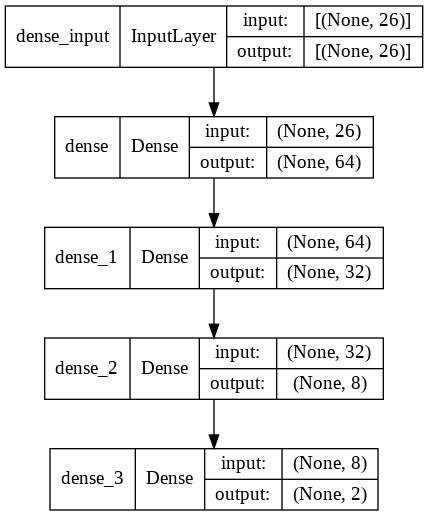

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(ann,
           to_file="model.png",
           show_shapes=True,
           show_layer_names=True,
          )

In [ ]:
ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1728      
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 4,090
Trainable params: 4,090
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Compiling ANN
ann.compile(optimizer="adam",loss=keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

# Save dulu

In [ ]:
# history = ann.fit(X_test, y_test, validation_split=0.3, epochs=100, batch_size=32, verbose=1)


In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('Model accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()


# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('Model loss')
# plt.ylabel('Loss')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Test'], loc='upper left')
# plt.show()

# Lanjutan

In [ ]:
batch_size = 10
early_stopping_patience = 10

# Add early stopping

my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='./model_{epoch:02d}.h5', 
                                       save_freq='epoch', 
                                       save_best_only=True,
                                       period = 10),
    tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
    )
]



history = ann.fit(X_train, y_train,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks = my_callbacks,
                    validation_split=0.3)
                    


Epoch 1/100
9/9 [==============================] - 2s 58ms/step - loss: 0.9354 - accuracy: 0.0964 - val_loss: 0.8172 - val_accuracy: 0.2222
Epoch 2/100
9/9 [==============================] - 0s 18ms/step - loss: 0.7317 - accuracy: 0.3373 - val_loss: 0.6954 - val_accuracy: 0.4722
Epoch 3/100
9/9 [==============================] - 0s 10ms/step - loss: 0.6041 - accuracy: 0.7349 - val_loss: 0.5807 - val_accuracy: 0.8056
Epoch 4/100
9/9 [==============================] - 0s 11ms/step - loss: 0.4784 - accuracy: 0.9277 - val_loss: 0.4744 - val_accuracy: 0.8056
Epoch 5/100
9/9 [==============================] - 0s 9ms/step - loss: 0.3674 - accuracy: 0.9398 - val_loss: 0.3791 - val_accuracy: 0.8333
Epoch 6/100
9/9 [==============================] - 0s 10ms/step - loss: 0.2844 - accuracy: 0.9157 - val_loss: 0.3176 - val_accuracy: 0.8611
Epoch 7/100
9/9 [==============================] - 0s 15ms/step - loss: 0.2262 - accuracy: 0.9157 - val_loss: 0.2790 - val_accuracy: 0.8611
Epoch 8/100
9/9 [====

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


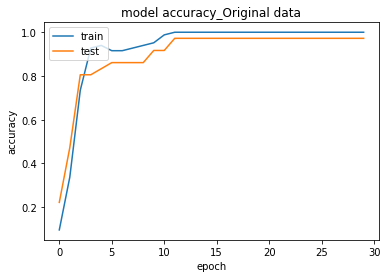

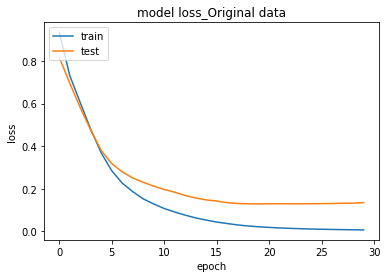

In [ ]:
def history_loss_acc(history,name):
    # list all data in history
    print(history.history.keys())
    
    # summarize history for accuracy
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy_'+name)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss_'+name)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

history_loss_acc(history, 'Original data')

In [ ]:
test_loss, test_acc = ann.evaluate(X_test,y_test)

2/2 [==============================] - 0s 6ms/step - loss: 0.1435 - accuracy: 0.9216


In [ ]:
print('test_acc: ',test_acc)

test_acc:  0.9215686321258545


In [ ]:
predictions = ann.predict(X_test)
#print ('so predict:',len(predictions))
#print('\npredictions[0].shape',predictions[0].shape)
#print('\nnp.sum(predictions)',np.sum(predictions[0]))
#print('\npredictions[:4]\n',predictions[:4])
#print('\ny_test',y_test[:4])
y_predict =[]
for i in range(len(predictions)):
    predict = np.argmax(predictions[i])
    y_predict.append(predict)
#predict = np.argmax(predictions[4])
#print ('predict\n',y_predict)

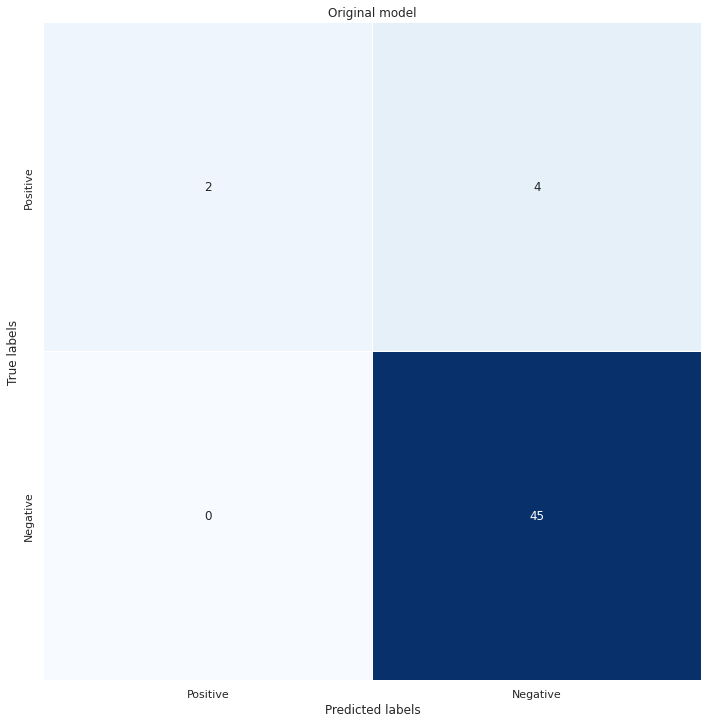

              precision    recall  f1-score   support

    Positive       1.00      0.33      0.50         6
    Negative       0.92      1.00      0.96        45

    accuracy                           0.92        51
   macro avg       0.96      0.67      0.73        51
weighted avg       0.93      0.92      0.90        51



In [ ]:
def evaluate_matrix(y_test, y_predict, name):
    cm = confusion_matrix(y_test, y_predict)
    cm_df = pd.DataFrame(cm, index=["Positive", "Negative"], columns=["Positive", "Negative"])

    plt.figure(figsize=(10, 10))

    sns.set(font_scale=1)

    ax = sns.heatmap(cm_df, annot=True, square=True, fmt='d', linewidths=.2, cbar=0, cmap=plt.cm.Blues)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

    plt.ylabel("True labels")
    plt.xlabel("Predicted labels")
    plt.tight_layout()
    plt.title(name)

    plt.show()

    print(classification_report(y_test, y_predict, target_names=["Positive", "Negative"]))
    
evaluate_matrix(y_test, y_predict, 'Original model')


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
print ('original positive cases: {}  and  total cases: {}'.format(pos, total) )
# transform the dataset
oversample = SMOTE(sampling_strategy=0.7, k_neighbors=3) #pos is equal to 50% neg
X_os, y_os = oversample.fit_resample(X_train, y_train)

order = np.arange(len(y_os))
np.random.shuffle(order)
X_os = X_os[order]
y_os = y_os[order]

pos_os, neg_os = np.bincount(y_os)
total_os = neg_os + pos_os
print ('\nAfter oversampling \nnegative cases: {}  \npositive cases: {} ({:.2f}% of total)'.format(neg_os, pos_os, 100 * pos_os/total_os ))

original positive cases: 19  and  total cases: 170

After oversampling 
negative cases: 106  
positive cases: 74 (41.11% of total)


In [ ]:
history_os = ann.fit(X_os, y_os,
                    epochs=100,
                    batch_size=batch_size,
                    callbacks = my_callbacks,
                    validation_split=0.3)

Epoch 1/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0883 - accuracy: 0.9760 - val_loss: 0.0729 - val_accuracy: 0.9818
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 0.0570 - val_accuracy: 0.9818
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 0.0200 - accuracy: 1.0000 - val_loss: 0.0442 - val_accuracy: 0.9818
Epoch 4/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 0.9818
Epoch 5/100
13/13 [==============================] - 0s 5ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.0285 - val_accuracy: 0.9818
Epoch 6/100
13/13 [==============================] - 0s 6ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 0.9818
Epoch 7/100
13/13 [==============================] - 0s 8ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.0260 - val_accuracy: 0.9818
Epoch 8/100
1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


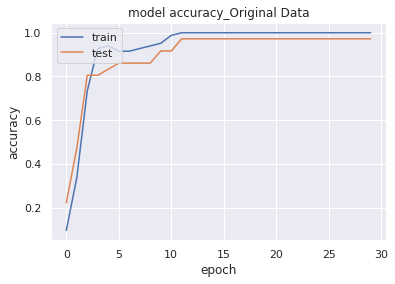

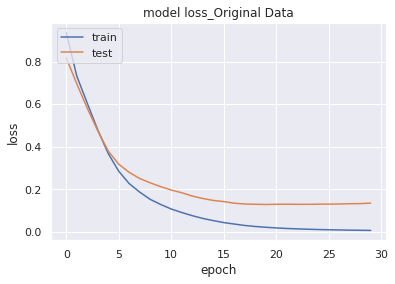

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


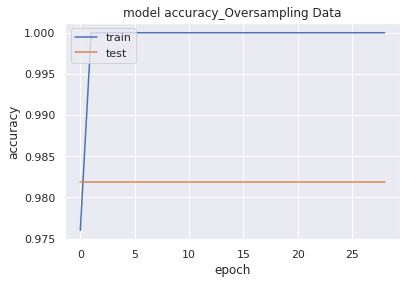

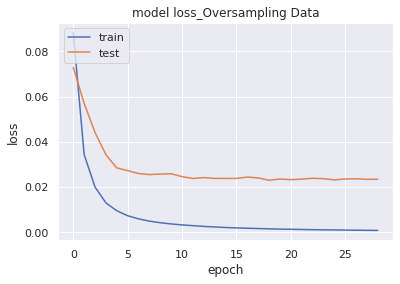

In [ ]:
history_loss_acc(history,'Original Data')
history_loss_acc(history_os,'Oversampling Data')


In [ ]:
test_loss_os, test_acc_os = ann.evaluate(X_test,y_test) 
print ('test_acc_os',test_acc_os)
predictions_os = ann.predict(X_test)
y_predict_os =[]
for i in range(len(predictions_os)):
    predict = np.argmax(predictions_os[i])
    y_predict_os.append(predict)
#predict = np.argmax(predictions[4])
#print ('predict_os\n',y_predict_os)

2/2 [==============================] - 0s 7ms/step - loss: 0.0363 - accuracy: 0.9804
test_acc_os 0.9803921580314636


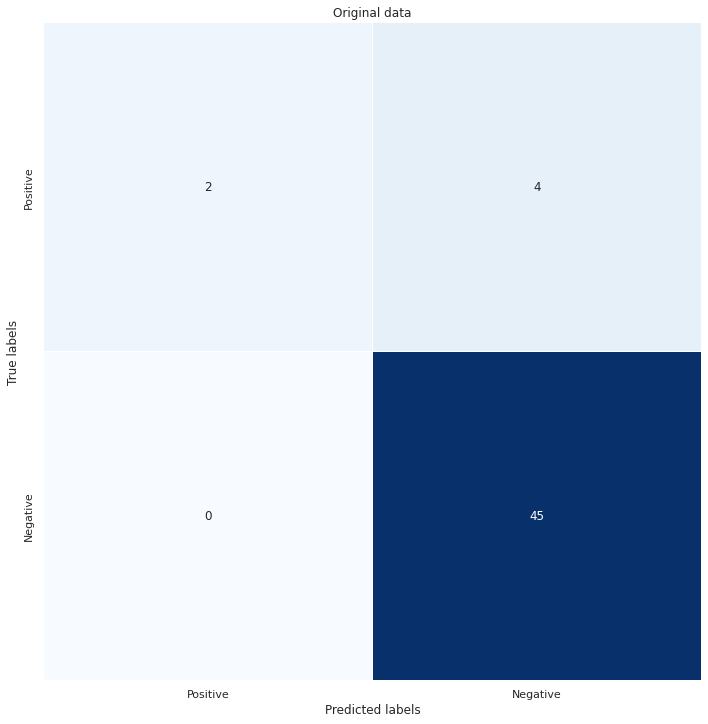

              precision    recall  f1-score   support

    Positive       1.00      0.33      0.50         6
    Negative       0.92      1.00      0.96        45

    accuracy                           0.92        51
   macro avg       0.96      0.67      0.73        51
weighted avg       0.93      0.92      0.90        51



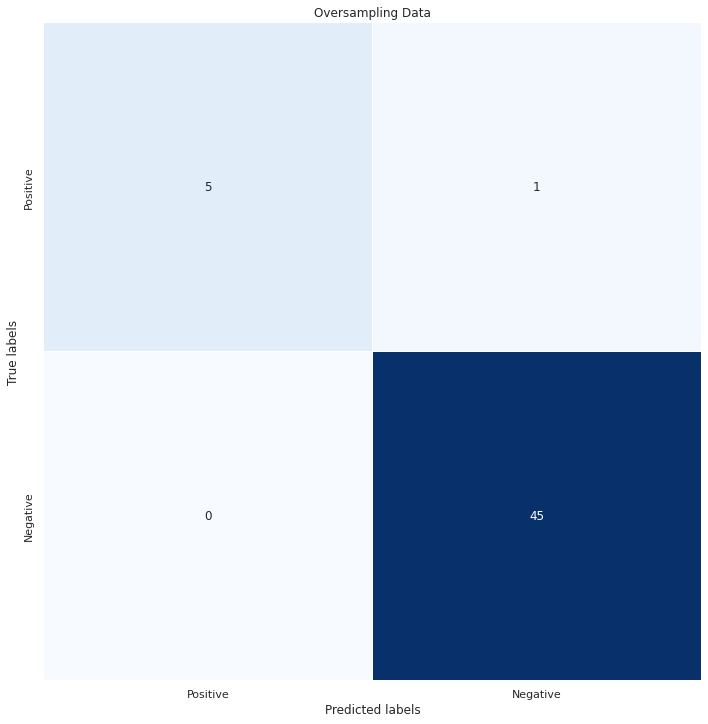

              precision    recall  f1-score   support

    Positive       1.00      0.83      0.91         6
    Negative       0.98      1.00      0.99        45

    accuracy                           0.98        51
   macro avg       0.99      0.92      0.95        51
weighted avg       0.98      0.98      0.98        51



In [ ]:
evaluate_matrix(y_test, y_predict,'Original data')
evaluate_matrix(y_test, y_predict_os, 'Oversampling Data')

model: Original data 
AUC = 0.9888888888888889


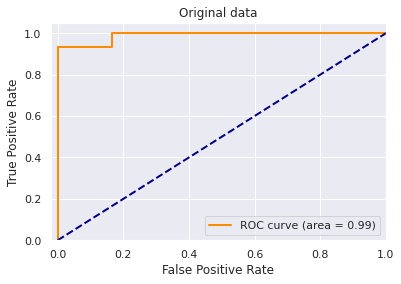

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_curve,roc_auc_score, auc
import matplotlib.pyplot as plt
from matplotlib import pyplot
#summarize score
#print(predictions[:,1], '\n',predictions[:,1].shape )
def ROC_curve(y_test,predictions,name):
    
    # calculate roc curves
    lr_fpr, lr_tpr, _ = roc_curve(y_test, predictions[:,1])
    print ('model: {} \nAUC = {}'. format(name, auc(lr_fpr, lr_tpr)))
    # plot the roc curve for the model
    lw = 2
    plt.plot(lr_fpr, lr_tpr, color="darkorange",
             lw=lw, label="ROC curve (area = %0.2f)" % auc(lr_fpr, lr_tpr))
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    plt.title(name)
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

ROC_curve(y_test,predictions,'Original data')

model: Original data 
AUC = 0.9888888888888889


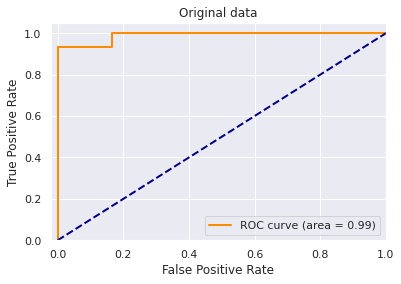

model: Oversampling Data 
AUC = 1.0


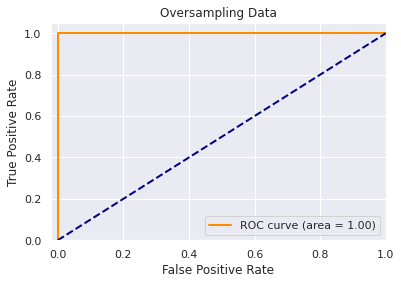

In [ ]:
ROC_curve(y_test, predictions,'Original data')
ROC_curve(y_test, predictions_os, 'Oversampling Data')

tot_rows 170 số cột:  2
0v8MGxNetjg_ 10.000_ 20.000


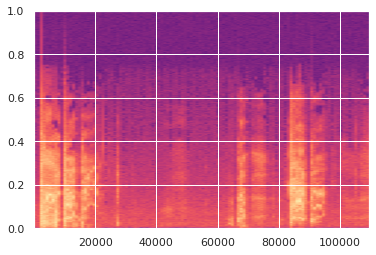

In [ ]:
cmap = plt.get_cmap('inferno')
tot_rows = train_csv.shape[0]
print ('tot_rows',tot_rows, 'số cột: ', train_csv.shape[1])
for i in range(1): #Thay range(1) = range(tot_rows)
    source = train_csv['file_properties'][i]
    filename = '../content/datasets/trial_covid/'+source
    y,sr = librosa.load(filename, mono=True, duration=10)
    plt.specgram(y, NFFT=2048, Fs=2, Fc=0, noverlap=128, cmap='magma', sides='default', mode='default', scale='dB');
    #plt.axis('off');
    plt.savefig(f'./{source[:-3].replace(".", "")}.png')
    print (source[:-4]) #Bỏ đi 4 kí tự cuối là ".wav"
    #plt.clf() 

S.shape (129, 431)


[Text(0.5, 1.0, 'Mel-frequency spectrogram 2')]

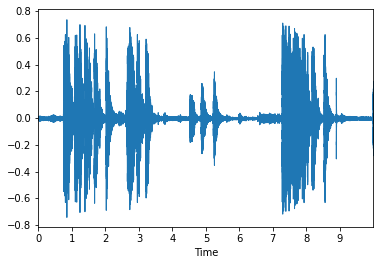

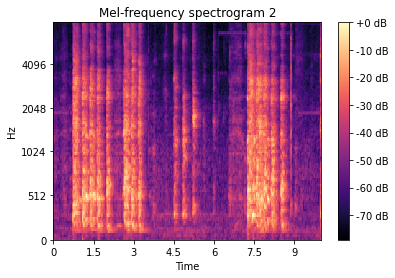

In [ ]:
y,sr = librosa.load('../content/datasets/trial_covid/1_oZWCKCGqA_ 10.000_ 20.000.wav', mono=True)
fig, ax = plt.subplots(sharex=True, sharey=True)
#draw sound with time axis 
librosa.display.waveplot(y, sr=sr, max_points=50000.0, x_axis='time')

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=129,fmax=8000)

print ('S.shape',S.shape)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram 2')